In [515]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns 
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

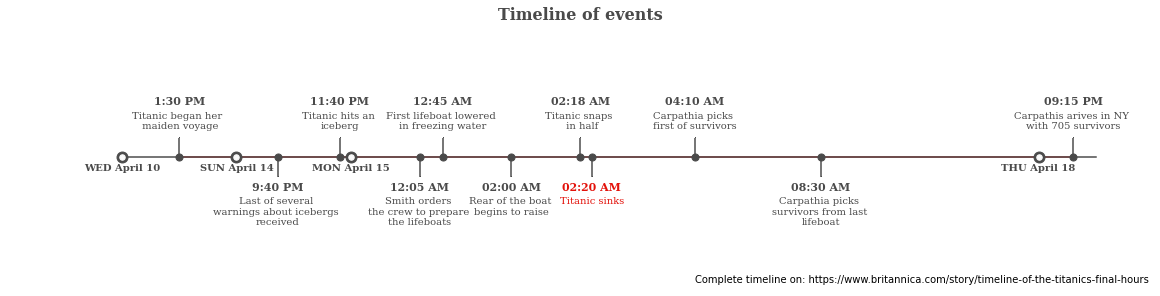

In [124]:

tl_dates = [
    "WED April 10",
    "SUN April 14",
    "MON April 15",
    "THU April 18"
]

tl_x = [1, 2, 3, 9]

tl_sub_x = [1.5, 2.36, 2.9, 3.6, 3.8, 4.4, 5, 5.1, 6, 7.1, 9.3]
tl_sub_times = [
    "1:30 PM",
    "9:40 PM",
    "11:40 PM",
    "12:05 AM",
    "12:45 AM",
    "02:00 AM",
    "02:18 AM",
    "02:20 AM",
    "04:10 AM",
    "08:30 AM",
    "09:15 PM",
]

tl_text = [
    "Titanic began her \n maiden voyage",
    "Last of several \nwarnings about icebergs \nreceived",
    "Titanic hits an \niceberg", 
    "Smith orders \nthe crew to prepare \nthe lifeboats",
    "First lifeboat lowered \nin freezing water",
    "Rear of the boat \nbegins to raise",
    "Titanic snaps \n in half",
    "Titanic sinks",
    "Carpathia picks \nfirst of survivors",
    "Carpathia picks \nsurvivors from last \nlifeboat",
    "Carpathis arives in NY \nwith 705 survivors"
]

# Set figure & Axes
fig, ax = plt.subplots(figsize=(16, 4), constrained_layout=True)
ax.set_ylim(-2, 2)
ax.set_xlim(0, 10)


# Timeline : line
ax.axhline(0, xmin=0.1, xmax=0.95, c='#4a4a4a', zorder=1)
# Timeline : Date Points
ax.scatter(tl_x, np.zeros(len(tl_x)), s=120, c='#4a4a4a', zorder=2)
ax.scatter(tl_x, np.zeros(len(tl_x)), s=30, c='#fafafa', zorder=3)
# Timeline : Time Points
ax.scatter(tl_sub_x, np.zeros(len(tl_sub_x)), s=50, c='#4a4a4a',zorder=4)

# Date Text
for x, date in zip(tl_x, tl_dates):
    ax.text(x, -0.2, date, ha='center', 
            fontfamily='serif', fontweight='bold',
            color='#4a4a4a')
    

# Stemplot : vertical line
levels = np.zeros(len(tl_sub_x))    
levels[::2] = 0.3
levels[1::2] = -0.3
markerline, stemline, baseline = ax.stem(tl_sub_x, levels, use_line_collection=True)    
plt.setp(baseline, zorder=0)
plt.setp(markerline, marker=',', color='#4a4a4a')
plt.setp(stemline, color='#4a4a4a')

# Text
for idx, x, time, txt in zip(range(1, len(tl_sub_x)+1), tl_sub_x, tl_sub_times, tl_text):
    ax.text(x, 1.3*(idx%2)-0.5, time, ha='center', 
            fontfamily='serif', fontweight='bold',
            color='#4a4a4a' if idx!=8 else '#e3120b', fontsize=11)
    
    ax.text(x, 1.3*(idx%2)-0.6, txt, va='top', ha='center', 
        fontfamily='serif',color='#4a4a4a' if idx!=8 else '#e3120b')

# Spine
for spine in ["left", "top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)

# link to complete timeline
ax.text(6,-1.9, 'Complete timeline on: https://www.britannica.com/story/timeline-of-the-titanics-final-hours', ha='left')

# Ticks    
ax.set_xticks([]) 
ax.set_yticks([]) 

# Title
ax.set_title("Timeline of events", fontweight="bold", fontfamily='serif', fontsize=16, color='#4a4a4a')

plt.show()

### Introduction 

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.


For this assignment the Titanic dataset that can be found on (Kaggle)[https://www.kaggle.com/c/titanic/data] is used.  
The data are already split into train and test set.  
Goal of this project is to use distance based learners (particularly KNN algorithm) and try to predict of a passenger survived or not.

### Dataset description

1. PassengerId: Unique passenger identification number
2. Survived: Did a passenger survive or not (0 = died, 1 = survived)
3. Pclass: Socio-economic status (1 = 1st; 2 = 2nd; 3 = 3rd)
4. Name: Name of Passenger
5. Sex: Sex of Passenger
6. Age: Passenger Age
7. SibSp: Number of Siblings (brother, sister, stepbrother, stepsister) /Spouses (husband, wife (mistresses and fiancés were ignored)) Aboard
8. Parch: Number of Parents/Children Aboard (Some children travelled only with a nanny, therefore parch=0 for them.)
9. Ticket: Ticket Number
10. Fare: Passenger Fare
11. Cabin: Cabin
12. Embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


In [490]:
data_path = 'C:/Users/anast/OneDrive/Desktop/MSc/MachineLearning/Assignments/Asgmt4_DistanceBasedLearning/Project 4/titanic/'
train_data = 'train.csv'
test_data = 'test.csv'
df_train = pd.read_csv(data_path + train_data)
df_test = pd.read_csv(data_path + test_data)

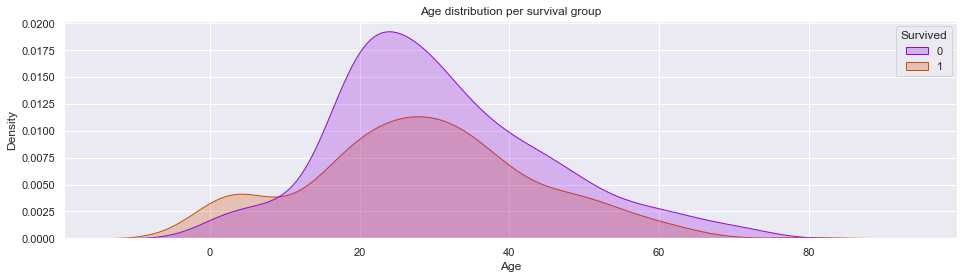

In [491]:
plt.figure(figsize=(16,4))
ageplot = sns.kdeplot(x='Age', data=df_train, hue='Survived', fill=True, legend=True, palette='gnuplot')
ageplot.title.set_text('Age distribution per survival group')
plt.show()

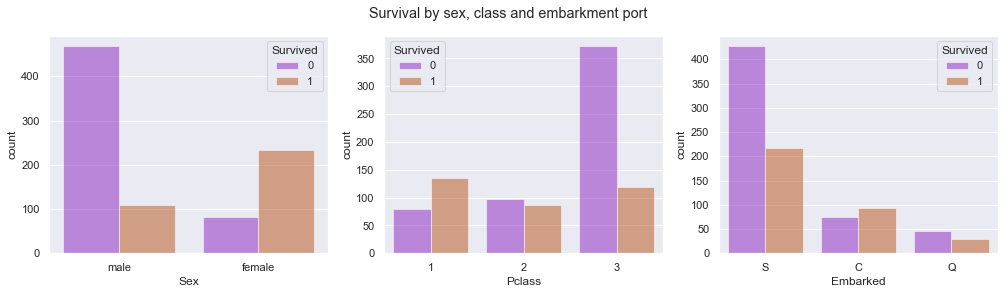

In [492]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 4))
fig.suptitle('Survival by sex, class and embarkment port')

for i, var in enumerate(['Sex', 'Pclass', 'Embarked']):
    sns.countplot(x=var, hue='Survived', palette='gnuplot', alpha=0.5, data=df_train, ax=axs[i])

### Feature engineering

To fix issues like missing data, I will be working only on train data.  
To generate features I will be working on the full dataset.



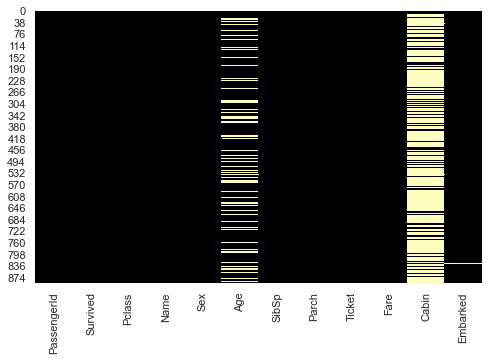

In [493]:
plt.figure(figsize=(8,5))
sns.heatmap(df_train.isnull(), cmap='magma', cbar = False)
plt.show()

In [494]:
titles = [x[1].split(' ')[1] for x in df_train['Name'].str.split(',')]
df_train['title'] = titles
print('Passenger title distribution:\n', df_train['title'].value_counts(), '\n')

title_mapping = {'Mr.': 'Mr', 'Master.': 'Mr', 'Mme.': 'Mr',
                 'Miss.': 'Miss', 'Mlle.': 'Miss', 'Ms.': 'Miss',
                 'Mrs.': 'Mrs',
                 'Dr.': 'Other', 'Rev.': 'Other', 'Major.': 'Other', 'Col.': 'Other', 'Capt.': 'Other',
                 'Don.': 'Royal', 'Jonkheer.': 'Royal', 'Lady.': 'Royal', 'Sir.': 'Royal', 'the': 'Royal',
                 }
df_train.replace({'title': title_mapping}, inplace=True)
print('Title distribution after mapping:\n', df_train['title'].value_counts())

titles = [x[1].split(' ')[1] for x in df_test['Name'].str.split(',')]
df_test['title'] = titles
df_test.replace({'title': title_mapping}, inplace=True)

Passenger title distribution:
 Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Col.           2
Mlle.          2
Capt.          1
Don.           1
Jonkheer.      1
Lady.          1
Ms.            1
Mme.           1
Sir.           1
the            1
Name: title, dtype: int64 

Title distribution after mapping:
 Mr       558
Miss     185
Mrs      125
Other     18
Royal      5
Name: title, dtype: int64


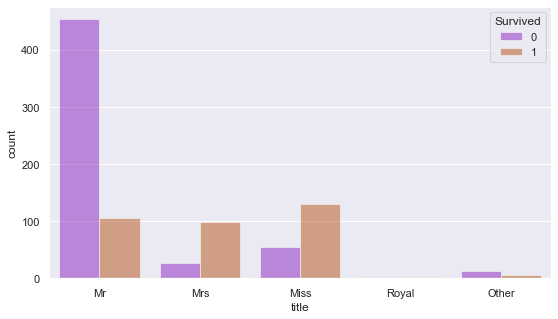

In [495]:
plt.figure(figsize=(9,5))
sns.countplot(x='title', hue='Survived', palette='gnuplot', alpha=0.5, data=df_train)
plt.show()

In [496]:
# fill the missing value for Age column with median of its title
titles = list(set(title_mapping.values()))
for title in titles:
    age = df_train.groupby('title')['Age'].median().loc[title]
    df_train.loc[(df_train.Age.isnull()) & (df_train.title == title), 'Age'] = age


In [497]:
titles = list(set(title_mapping.values()))
for title in titles:
    age_train = df_train.groupby('title')['Age'].median().loc[title]
    df_train.loc[(df_train.Age.isnull()) & (df_train.title == title), 'Age'] = age_train

    age_test = df_train.groupby('title')['Age'].median().loc[title]
    df_test.loc[(df_test.Age.isnull()) & (df_test.title == title), 'Age'] = age_test

In [498]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

df_train['Alone'] = df_train['FamilySize'] == 1
df_train['Couple'] = df_train['FamilySize'] == 2
df_train['SmallFamily'] = df_train['FamilySize'] == 3
df_train['LargeFamily'] = df_train['FamilySize'] > 3

df_test['Alone'] = df_test['FamilySize'] == 1
df_test['Couple'] = df_test['FamilySize'] == 2
df_test['SmallFamily'] = df_test['FamilySize'] == 3
df_test['LargeFamily'] = df_test['FamilySize'] > 3

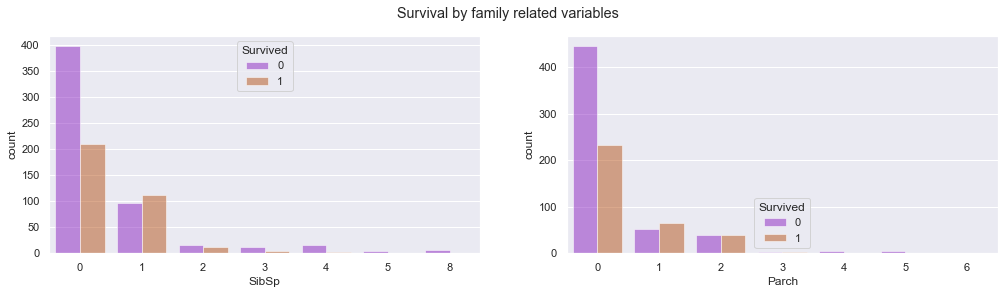

In [499]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 4))
fig.suptitle('Survival by family related variables')

for i, var in enumerate(['SibSp', 'Parch']):
    sns.countplot(x=var, hue='Survived', fill=True, palette='gnuplot', alpha=0.5, data=df_train, ax=axs[i])

The first letter of the cabin, is the deck where the cabin located. Cabin deck is associated with passeneger socio-economic status (pcalss). I will name the missing cabin as "M", as I believe it to be cabin information of a victim (it has high death rate). 

In [500]:
df_train.loc[df_train.Cabin.isnull(), 'Cabin'] = 'M'
df_train['Deck'] = [x[0] for x in df_train['Cabin']]

df_test.loc[df_test.Cabin.isnull(), 'Cabin'] = 'M'
df_test['Deck'] = [x[0] for x in df_test['Cabin']]


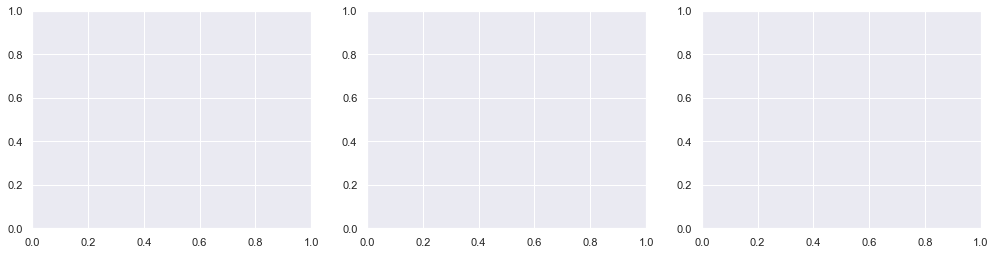

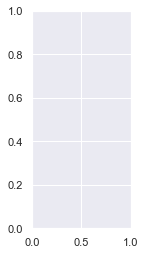

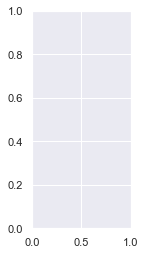

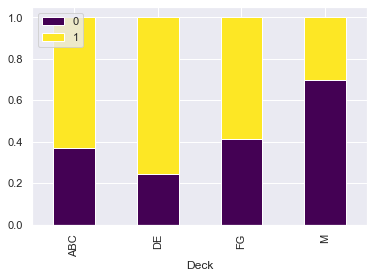

In [501]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 4))

plt.subplot(131)
foo1 = df_train[['Deck', 'Pclass']].pivot_table(index='Deck', columns='Pclass', aggfunc=len, fill_value=0)
foo1 = foo1.apply(lambda x:x/sum(x), axis=1)

pt1 = foo1.plot.bar(stacked=True, legend=False, cmap='viridis')
patches, labels = pt1.get_legend_handles_labels()
pt1.legend(patches, labels, loc='upper left')


plt.subplot(132)
foo2 = df_train[['Deck', 'Survived']].pivot_table(index='Deck', columns='Survived', aggfunc=len, fill_value=0)
foo2 = foo2.apply(lambda x:x/sum(x), axis=1)

pt2 = foo2.plot.bar(stacked=True, legend=False, cmap='viridis')
patches, labels = pt2.get_legend_handles_labels()
pt2.legend(patches, labels, loc='upper left')


# Group the decks in 3 groups 
df_train.loc[df_train['Deck'] == 'T', 'Deck'] = 'A'
df_train['Deck'] = df_train['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_train['Deck'] = df_train['Deck'].replace(['D', 'E'], 'DE')
df_train['Deck'] = df_train['Deck'].replace(['F', 'G'], 'FG')

df_test.loc[df_test['Deck'] == 'T', 'Deck'] = 'A'
df_test['Deck'] = df_test['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_test['Deck'] = df_test['Deck'].replace(['D', 'E'], 'DE')
df_test['Deck'] = df_test['Deck'].replace(['F', 'G'], 'FG')


plt.subplot(133)
foo3 = df_train[['Deck', 'Survived']].pivot_table(index='Deck', columns='Survived', aggfunc=len, fill_value=0)
foo3 = foo3.apply(lambda x:x/sum(x), axis=1)

pt3 = foo3.plot.bar(stacked=True, legend=False, cmap='viridis')
patches, labels = pt3.get_legend_handles_labels()
pt3.legend(patches, labels, loc='upper left')

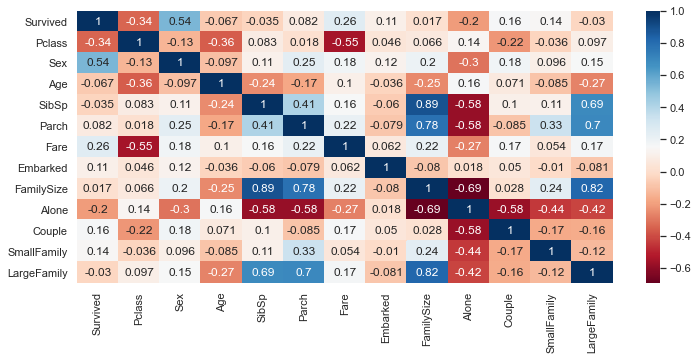

In [502]:
# Feature correlations

df_train['Sex'] = df_train['Sex'].map({'male':0, 'female':1})
df_train['Embarked'] = df_train['Embarked'].fillna('S')
df_train['Embarked'] = df_train['Embarked'].map({'S':0, 'C':1, 'Q':2})
df_train = df_train.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

df_test['Sex'] = df_test['Sex'].map({'male':0, 'female':1})
df_test['Embarked'] = df_test['Embarked'].fillna('S')
df_test['Embarked'] = df_test['Embarked'].map({'S':0, 'C':1, 'Q':2})
df_test = df_test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)


plt.subplots(figsize = (12,5))
sns.heatmap(df_train.corr(), cmap = 'RdBu', cbar = True, annot = True)
plt.show()

In [503]:
# one hot encode categorical features and then apply min-max scalling 
df_full = pd.concat([df_train, df_test]).reset_index(drop=True)

train_shape = df_train.shape
test_shape = df_test.shape


df_full = pd.get_dummies(df_full)

df_train = df_full.iloc[:train_shape[0],]
df_test = df_full.iloc[train_shape[0]:]


x_train = df_train.drop(columns = ['Survived'])
y_train = df_train['Survived'].astype(int)

x_test = df_test.drop(columns = ['Survived'])


scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [514]:
# model building

clf = KNeighborsClassifier()
params = {'n_neighbors': list(range(3,21))}

# Using ROC_AUC as metric has a better result than using accuracy. 
gs = GridSearchCV(clf, param_grid= params, cv = 5, scoring = "roc_auc", verbose=1, n_jobs=-1)
gs.fit(x_train, y_train)
print(gs.best_score_)
print(gs.best_estimator_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
0.8383536543311527
KNeighborsClassifier(n_neighbors=6)
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   10.4s finished


In [517]:
classifier = KNeighborsClassifier(n_neighbors=6)
classifier.fit(x_train, y_train)
preds = classifier.predict(x_test)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [521]:
classifier.predict(x_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [533]:
pd.DataFrame(x_test).isnull().any()

0      False
1      False
2      False
3      False
4      False
       ...  
204    False
205    False
206    False
207    False
208    False
Length: 209, dtype: bool